/Users/Daniel/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_70763/2943001435.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # Rojo para negativo, verde para positivo


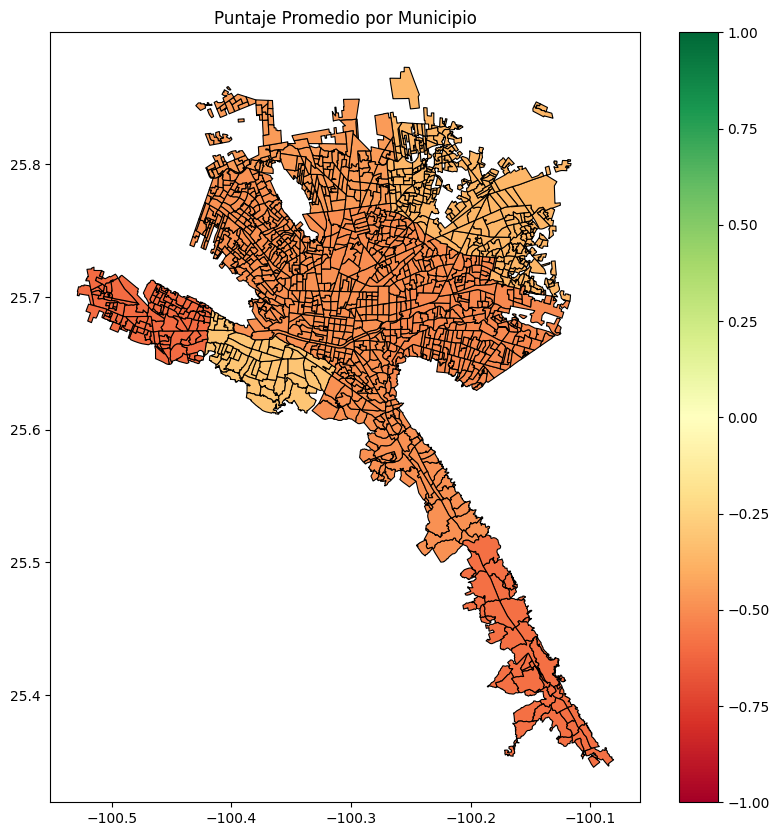

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

# Carga del archivo SHP
shapefile_path2 = "2023_1_19_A/2023_1_19_A.shp"  
gdf2 = gpd.read_file(shapefile_path2)

# Definir los valores de CVE_MUN que corresponden a los municipios
cve_mun_values = {
    '006': 'Apodaca', 
    '019': 'San Pedro Garza García', 
    '021': 'Escobedo', 
    '026': 'Guadalupe', 
    '039': 'Monterrey', 
    '046': 'San Nicolás', 
    '048': 'Santa Catarina', 
    '049': 'Santiago'
}

# Filtra el GeoDataFrame por los valores de CVE_MUN
gdf2_delimited = gdf2[gdf2['CVE_MUN'].isin(cve_mun_values.keys())]

# Cargar el DataFrame con los puntajes
df = pd.read_csv('df_con_entidades.csv')

# Lista de entidades (municipios) preseleccionadas
entidades_preseleccionadas = list(cve_mun_values.values())

# Función para filtrar las filas que contengan al menos una de las entidades preseleccionadas
def filtrar_filas_por_entidades(df, entidades):
    entidades = [e.lower() for e in entidades]
    filas_filtradas = df[df['entidades'].apply(
        lambda x: any(entidad in entidad_lista.lower() for entidad in entidades for entidad_lista in eval(x))
        if x != '[]' else False  # Evitar listas vacías
    )]
    return filas_filtradas

# Filtramos las filas por entidades preseleccionadas
filas_filtradas = filtrar_filas_por_entidades(df, entidades_preseleccionadas)

# Calcular el puntaje promedio por municipio
promedio_puntajes = {}
for municipio in entidades_preseleccionadas:
    filas_municipio = filas_filtradas[filas_filtradas['entidades'].apply(
        lambda x: municipio.lower() in [entidad.lower() for entidad in eval(x)])]
    if not filas_municipio.empty:
        promedio_puntajes[municipio] = np.mean(filas_municipio['Puntaje'])
    else:
        promedio_puntajes[municipio] = None

# Asignar los puntajes promedios a los códigos CVE_MUN correspondientes
gdf2_delimited['Puntaje'] = gdf2_delimited['CVE_MUN'].map({cve: promedio_puntajes[mun] for cve, mun in cve_mun_values.items()})

# Configurar el colormap (escala de colores) para que los valores negativos sean rojos y los positivos verdes
norm = Normalize(vmin=-1, vmax=1)
cmap = cm.get_cmap('RdYlGn')  # Rojo para negativo, verde para positivo

# Graficar el GeoDataFrame con los colores basados en el puntaje
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf2_delimited.plot(column='Puntaje', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='black', legend=True, norm=norm)

# Añadir título y mostrar el gráfico
plt.title('Puntaje Promedio por Municipio')
plt.show()

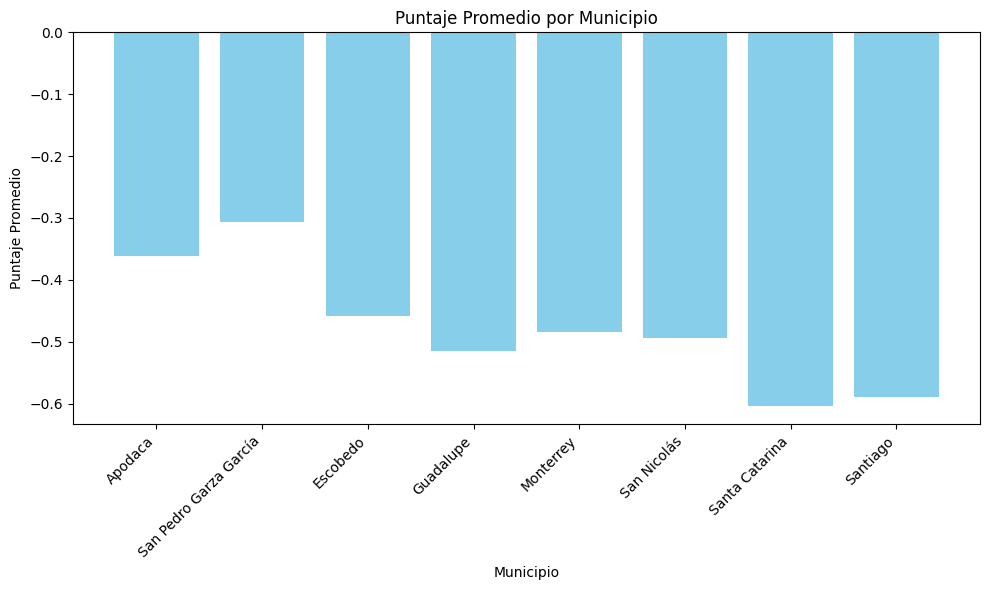

In [50]:
# Filtrar los puntajes que no son None
puntajes_validos = {municipio: puntaje for municipio, puntaje in promedio_puntajes.items() if puntaje is not None}

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.bar(puntajes_validos.keys(), puntajes_validos.values(), color='skyblue')
plt.xlabel('Municipio')
plt.ylabel('Puntaje Promedio')
plt.title('Puntaje Promedio por Municipio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ajusta el layout para evitar que las etiquetas se corten
plt.show()


In [153]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

# Carga del archivo SHP
shapefile_path3 = "Colonias/Colonias.shp"  
gdf3 = gpd.read_file(shapefile_path3)


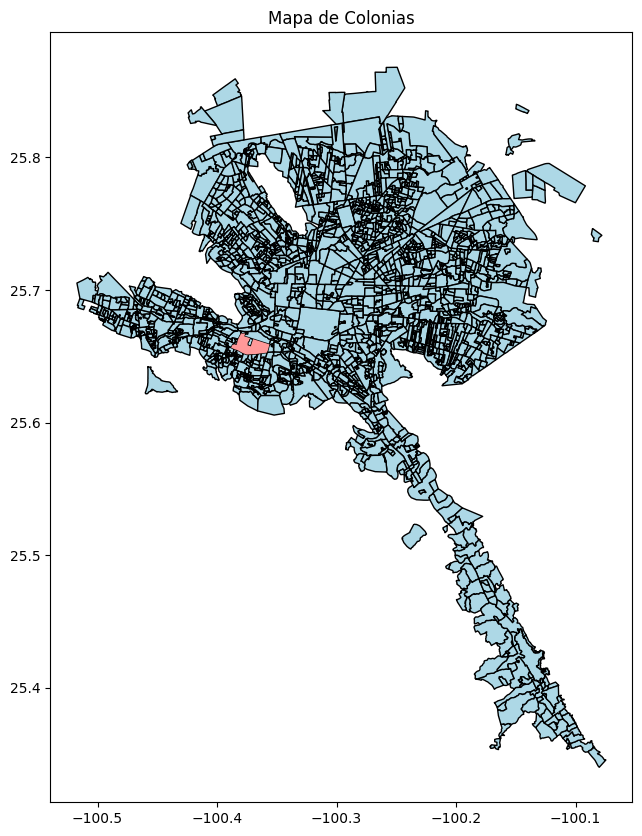

In [171]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el archivo shapefile
shapefile_path = "Colonias/Colonias.shp"  
gdf = gpd.read_file(shapefile_path)

# Filtrar los municipios y el estado
municipios = ['APODACA', 'SAN PEDRO GARZA GARCÍA', 'GENERAL ESCOBEDO', 'GUADALUPE', 'MONTERREY', 'SAN NICOLÁS DE LOS GARZA', 'SANTA CATARINA', 'SANTIAGO']
gdf_filtered = gdf[(gdf['MUN_NAME'].isin(municipios)) & (gdf['ST_NAME'] == 'NUEVO LEON')]

# Crear un mapa base con el tono azul
ax = gdf_filtered.plot(color='lightblue', edgecolor='black', figsize=(10, 10))

# Pintar de rojo el área que tiene SETT_NAME = "DEL VALLE"
gdf_del_valle = gdf_filtered[gdf_filtered['SETT_NAME'] == 'DEL VALLE']
gdf_del_valle.plot(ax=ax, color='#ff9999')

# Añadir título y mostrar el mapa
plt.title('Mapa de Colonias')
plt.show()


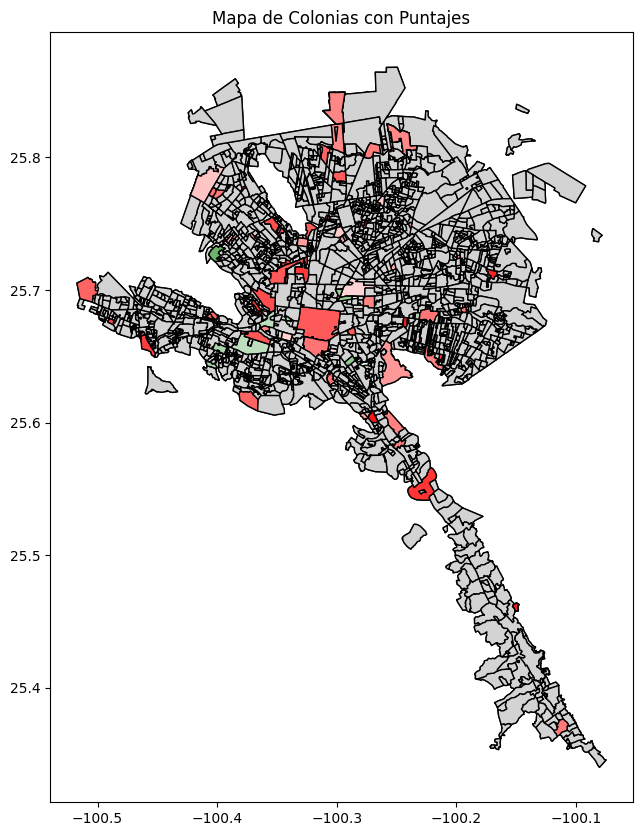

In [173]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Cargar el archivo shapefile
shapefile_path = "Colonias/Colonias.shp"  
gdf = gpd.read_file(shapefile_path)

# Cargar el archivo CSV con las colonias y puntajes
csv_path = "df_con_colonias.csv" 
df = pd.read_csv(csv_path)
# Convertir la columna 'colonia' a mayúsculas
df['colonia'] = df['colonia'].str.upper()

# Filtrar los municipios y el estado
municipios = ['APODACA', 'SAN PEDRO GARZA GARCÍA', 'GENERAL ESCOBEDO', 'GUADALUPE', 'MONTERREY', 'SAN NICOLÁS DE LOS GARZA', 'SANTA CATARINA', 'SANTIAGO']
gdf_filtered = gdf[(gdf['MUN_NAME'].isin(municipios)) & (gdf['ST_NAME'] == 'NUEVO LEON')]

# Hacer merge entre el shapefile y el CSV usando la columna de las colonia
gdf_filtered = gdf_filtered.merge(df, left_on='SETT_NAME', right_on='colonia', how='left')

# Crear el mapa base con un tono azul claro
ax = gdf_filtered.plot(color='lightblue', edgecolor='black', figsize=(10, 10))

# Crear una función que mapee los colores de acuerdo con los puntajes
def get_color(puntaje):
    if pd.isna(puntaje):  # Si no hay puntaje, dejar sin color
        return 'lightgray'
    cmap = mcolors.LinearSegmentedColormap.from_list('colormap', ['red', 'white', 'green'])
    norm = mcolors.Normalize(vmin=df['Puntaje'].min(), vmax=df['Puntaje'].max())
    return cmap(norm(puntaje))

# Aplicar colores a las colonias en función del puntaje
gdf_filtered['color'] = gdf_filtered['Puntaje'].apply(get_color)

# Pintar las colonias en el mapa
gdf_filtered.plot(ax=ax, color=gdf_filtered['color'], edgecolor='black')

# Añadir título y mostrar el mapa
plt.title('Mapa de Colonias con Puntajes')
plt.show()
